<a href="https://colab.research.google.com/github/noahruiz416/Homelessness_Clustering_Comparisons/blob/master/Homeless_Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OBJECTIVE (Copied from David Little):

This project consists of 4 distinct tasks revolving around a dataset tracking the services used by homeless people in Maricopa county, Arizona. The overarching objective was to design a risk model that assessed the likelihood of people falling back into homelessness after utilizing certain services. An essential component of this was to identify natural clusters of usage patterns within the data. This allowed us to observe how distinct groups of people flowed through the system and to identify success stories within the data. While our team settled on the BIRCH algorithm, we are interested in identifying other clustering algorithms that may be more efficient or may tell us an interesting story from the data. We are interested in any approach identified. 



Author of this notebook: Noah Ruiz

This specific file is an initial EDA of the various tasks, within this file we hope to gain a better understanding of the various services used, to provide better insight into the behavior of homeless people. In my specific implementation I hope to improve hyperparameter tuning, implement various distance metrics, apply new visualiztion technqiues and introduce various approaches to clustering, to try and gain a better understaning of homeless activity.

In [2]:
#imports 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns 

In [3]:
#loading the data
url = 'https://raw.githubusercontent.com/djlittle/Homelessness_Clustering_Comparisons/master/Data/HMIS%20Data%20Extract.csv'

initial_df = pd.read_csv(url) # Importing data

print(initial_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29345 entries, 0 to 29344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   personalid               29345 non-null  int64  
 1   projecttype_1_bednights  9832 non-null   float64
 2   projecttype_1_count      9832 non-null   float64
 3   projecttype_2_count      1520 non-null   float64
 4   projecttype_3_count      1731 non-null   float64
 5   projecttype_4_count      7351 non-null   float64
 6   projecttype_6_count      2211 non-null   float64
 7   projecttype_7_count      8041 non-null   float64
 8   projecttype_8_count      66 non-null     float64
 9   projecttype_10_count     114 non-null    float64
 10  projecttype_12_count     228 non-null    float64
 11  projecttype_13_count     3257 non-null   float64
 12  projecttype_14_count     17334 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 2.9 MB
None


In [4]:
#count of null values 
initial_df.isna().sum() #large amounts of null values

personalid                     0
projecttype_1_bednights    19513
projecttype_1_count        19513
projecttype_2_count        27825
projecttype_3_count        27614
projecttype_4_count        21994
projecttype_6_count        27134
projecttype_7_count        21304
projecttype_8_count        29279
projecttype_10_count       29231
projecttype_12_count       29117
projecttype_13_count       26088
projecttype_14_count       12011
dtype: int64

In [5]:
#number of unique ids / people
initial_df['personalid'].value_counts().count()

29345

In [6]:
##initial eda 
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29345 entries, 0 to 29344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   personalid               29345 non-null  int64  
 1   projecttype_1_bednights  9832 non-null   float64
 2   projecttype_1_count      9832 non-null   float64
 3   projecttype_2_count      1520 non-null   float64
 4   projecttype_3_count      1731 non-null   float64
 5   projecttype_4_count      7351 non-null   float64
 6   projecttype_6_count      2211 non-null   float64
 7   projecttype_7_count      8041 non-null   float64
 8   projecttype_8_count      66 non-null     float64
 9   projecttype_10_count     114 non-null    float64
 10  projecttype_12_count     228 non-null    float64
 11  projecttype_13_count     3257 non-null   float64
 12  projecttype_14_count     17334 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 2.9 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac1d46cc10>,
      dtype=object)

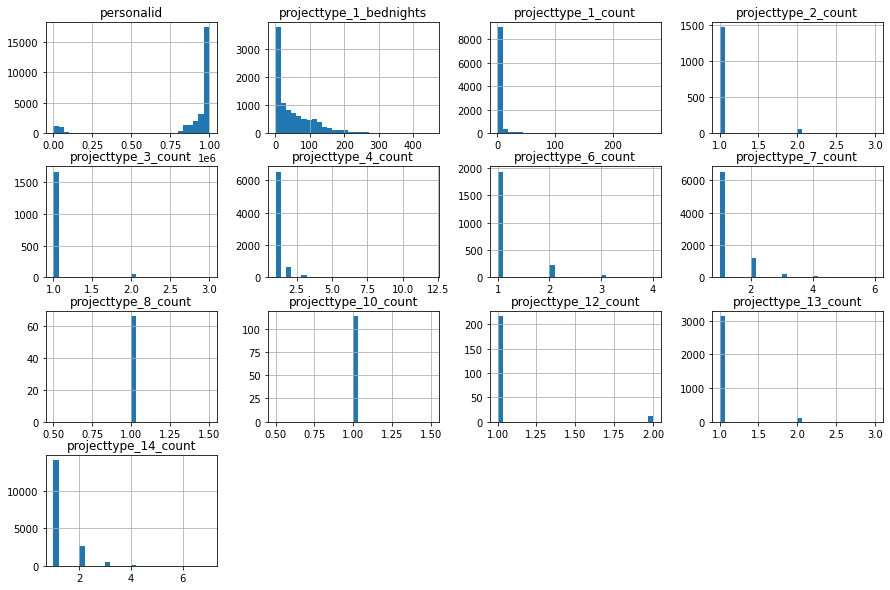

In [7]:
initial_df.hist(bins = 30, figsize=(15, 10))

In [8]:
#visualizing each project variable in 1 dimension
def plot_one(input_data, var_name):
  dat = np.array(input_data[f'{var_name}'])
  plt.scatter(dat.flatten(), [0]*len(dat))

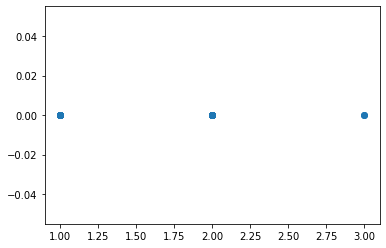

In [10]:
plot_one(initial_df, 'projecttype_2_count')

In [12]:
#renaming columns based off the data dictionary
initial_df.rename(columns={'projecttype_1_bednights':'EmergencyShelterNights', 'projecttype_1_count':'Emergency Shelter',
                   'projecttype_2_count': 'Transitional Housing', 'projecttype_3_count': 'PH'
                   ,'projecttype_4_count': 'StreetOutReach', 'projecttype_6_count': 'ServicesOnly', 
                   'projecttype_7_count': 'Other', 'projecttype_8_count': 'Safe Haven', 'projecttype_10_count': 'PH No Disability',
                   'projecttype_12_count': 'HomelessnessPrevention', 'projecttype_13_count': 'PH Rapid',
                   'projecttype_14_count': 'CoordinatedAssessment'}, inplace=True)

## Data Cleaning Portion

In [119]:
#dealing with null values, 
df = initial_df.iloc[:, 1:]
df.fillna(-1, inplace=True) # Filling null values of the data frame with -1. 
# Other approaches to null handling are also of interest here.

df.isna().sum() # clears all null values and replaces them with -1 

df.columns

Index(['EmergencyShelterNights', 'Emergency Shelter', 'Transitional Housing',
       'PH', 'StreetOutReach', 'ServicesOnly', 'Other', 'Safe Haven',
       'PH No Disability', 'HomelessnessPrevention', 'PH Rapid',
       'CoordinatedAssessment'],
      dtype='object')

## Unsupervised Learning Methods

### Initial Approach with PCA, to try and see if it is possible to break down variance into principal components

In [109]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#utilizing PCA for initial component analysis, using the MinMaxScaler Transformation

scaler = MinMaxScaler()
df_rescaled = scaler.fit_transform(df)

pca = PCA(n_components = 0.99)
pca.fit(df_rescaled)
reduced = pca.transform(df_rescaled)

In [110]:
#min max scaler seems to perform better than the standard scaler 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.2132796 , 0.16712924, 0.1458761 , 0.11206976, 0.09651151,
       0.08975186, 0.05271409, 0.03938979, 0.02814876, 0.02578793,
       0.01635883, 0.01298253])

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#utilizing PCA for initial component analysis, using the NormalizedScaler Transformation

standScaler = StandardScaler()
df_rescaled = standScaler.fit_transform(df)

pca_norm = PCA(n_components = 0.99)
pca_norm.fit(df_rescaled)
reduced = pca_norm.transform(df_rescaled)

In [55]:
#standard scaler reports less varaince explained in components
explained_variance = pca_norm.explained_variance_ratio_
explained_variance

array([0.14306347, 0.10334754, 0.0905217 , 0.08794494, 0.08431447,
       0.08363459, 0.08280793, 0.08028351, 0.07392526, 0.06955158,
       0.06002184, 0.04058316])

In [60]:
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=PCnames,index=df.columns)

([<matplotlib.axis.XTick at 0x7fac14e25610>,
 <a list of 12 Text major ticklabel objects>)

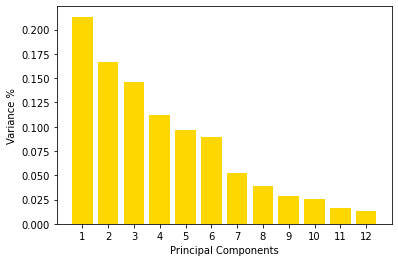

In [61]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

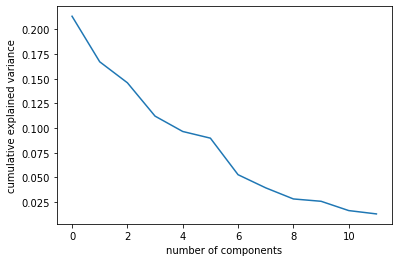

In [65]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

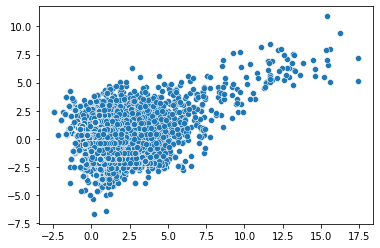

In [92]:
#from this initial plot it seems that a clear cluster forms in the principal components
sns.scatterplot(x = reduced[:, 0], y = reduced[:, 1])

In [112]:
#plotting explained variance, utilizing the plotly package
import plotly.express as px

exp_var = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var.shape[0] + 1),
    y=exp_var,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [129]:
fig = px.scatter(x=reduced[:, 0], y=reduced[:, 1])
fig.show()

### Approach Number 2 Implmenting Clustering Methods